# Computer Vision, Assignment 3: Epipolar Geometry

In this assignment, you will study epipolar geometry. 
You will use the fundamental matrix and the essential matrix for simultaneously reconstructing the 3D structure and the camera motion from two images.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are ``mandatory'' in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).

In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.io

from supplied import pflat, plot_camera, rital

# The Fundamental Matrix

#### *Theoretical exercises 1-4* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/kronan1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/kronan2.JPG" width="250px">
    <figcaption>Figure1. kronan1.jpg and kronan2.jpg</figcaption>
</figure>

In this exercise you will compute the fundamental matrix for the two images above, showing a part of the fort Kronan in Gothenburg. The calibration matrix $K$ is assumed to be unknown. The file `compEx1data.mat` contains a cell `x` with matched points for the two images.

### Task 1.1
Compute normalization matrices $N_1$ and $N_2$. These matrices should subtract the mean and re-scale using the standard deviation, as in assignment 2.
Normalize the image points of the two images with $N_1$ and $N_2$, respectively.

In [2]:
# ------ Your code here ------
data = sp.io.loadmat('data/compEx1data.mat')
x = data['x']

x1=x[0,0]
x2=x[1,0]

def normalization_matrix(x):

    uv = x[:2, :]
    
    mean = np.mean(uv, axis=1, keepdims=True)
    std = np.std(uv, axis=1, keepdims=True)

    N = np.array([
        [1/std[0,0], 0,           -mean[0,0]/std[0,0]],
        [0,          1/std[1,0],  -mean[1,0]/std[1,0]],
        [0,          0,            1]
    ])
    
    return N, mean, std
    
# Compute N1 and N2
N1, mean1, std1 = normalization_matrix(x1)
N2, mean2, std2 = normalization_matrix(x2)

# Normalize the image points
x1_norm_h = N1 @ x1
x2_norm_h = N2 @ x2

### Task 1.2
Set up the matrix $M$ in the eight point algorithm (8 is the minimum number of points, you should use all the points here), and solve the homogeneous least squares system using SVD. 
Check that the minimum singular value and $||Mv||$ are both small. Construct the $3 \times 3$ matrix $\tilde F$ from the solution $v$. This matrix should approximately satisfy $\tilde x_2^T \tilde F \tilde x_1 = 0$, where $\tilde x_j$ are normalized image points. Write the code as a function which would be useful later. 

In [3]:
def estimate_F_DLT(x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    '''
    # Your code here
    x1s = pflat(x1s)
    x2s = pflat(x2s)
    
    x1, y1, z1 = x1s
    x2, y2, z2 = x2s

    N = x1.shape[0]
    M = np.zeros((N, 9))
    
    # Form M as in lecture 6
    M[:, 0] = x2 * x1     
    M[:, 1] = x2 * y1     
    M[:, 2] = x2 * z1      
    M[:, 3] = y2 * x1      
    M[:, 4] = y2 * y1      
    M[:, 5] = y2 * z1      
    M[:, 6] = z2 * x1      
    M[:, 7] = z2 * y1      
    M[:, 8] = z2 * z1     

    # Solve using svd
    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1, :]                 # Extract smallest singular value
    F_tilde = v.reshape(3, 3)  
    
    sigma_min = S[-1]
    residual = np.linalg.norm(M @ v)

    return F_tilde, sigma_min, residual

You must also make sure that $\det(\tilde{F}) = 0$ for your solution. Make a separate function that explicitly enforces the constraint, as this will be convenient for you later.

In [4]:
def enforce_fundamental(F_approx):
    '''
    F_approx - Approximate Fundamental matrix (3x3)
    '''
    # Your code here
    
    # Solve by eqn 20 in lecture 6
    U, S, Vt = np.linalg.svd(F_approx)
    
    # Set smallest singular value, sigma3=0
    S[2] = 0.0
    
    # Reconstruct the enforced F
    F_rank2 = U @ np.diag(S) @ Vt
    
    return F_rank2

Estimate $\tilde{F}$ and check that the epipolar constraints $\tilde{x}_2^T \tilde{F} \tilde{x}_1 = 0$ are roughly fulfilled.


In [5]:
# ------ Your code here ------

# Estimate F_tilde 
F_tilde_approx, sigma_min, residual = estimate_F_DLT(x1_norm_h, x2_norm_h)
F_tilde = enforce_fundamental(F_tilde_approx)

# Check epipolar constraints
vals = np.sum(x2_norm_h * (F_tilde @ x1_norm_h), axis=0)

print("\n================ Fundamental Matrix Estimation Diagnostics ================\n")

print(f" Smallest singular value of M : {sigma_min: .6e}")
print(f" Residual ||M v||             : {residual: .6e}")

print("\n Estimated F_tilde (rank-2 enforced):")
print("-------------------------------------")
print(F_tilde)

print("\n Epipolar Constraint Check (x2^T F x1 ≈ 0)")
print("------------------------------------------")
print(f" Mean violation : {np.mean(np.abs(vals)): .6e}")
print(f" Max violation  : {np.max(np.abs(vals)): .6e}")

print("\n Largest epipolar constraint value:")
print( np.max(vals))

print("\n===========================================================================\n")




================ Fundamental Matrix Estimation Diagnostics ================

 Smallest singular value of M :  4.965450e-02
 Residual ||M v||             :  4.965450e-02

 Estimated F_tilde (rank-2 enforced):
-------------------------------------
[[ 5.69896256e-04  4.95605161e-02 -1.30416527e-01]
 [-5.98220907e-02 -2.93922906e-03  6.86836633e-01]
 [ 1.52520147e-01 -6.94209478e-01  3.72136140e-03]]

 Epipolar Constraint Check (x2^T F x1 ≈ 0)
------------------------------------------
 Mean violation :  7.158981e-04
 Max violation  :  7.951132e-03

 Largest epipolar constraint value:
0.00795113248018417




### Task 1.3



Compute the un-normalized fundamental matrix $F$ (using the formula from exercise 4) and the epipolar lines $l = F x_1$. Pick 20 points in the second image at random and plot these in the same figure as the image.
Also plot the corresponding epipolar lines in the same image using the function `rital`. Verify that the points are close to the corresponding epipolar lines.






Un-normalized F:
 [[ 2.98731653e-09  3.27806090e-07 -5.08648427e-04]
 [-4.11282268e-07 -2.54980866e-08  2.35119098e-03]
 [ 6.33890665e-04 -2.31714260e-03 -8.81186521e-02]]


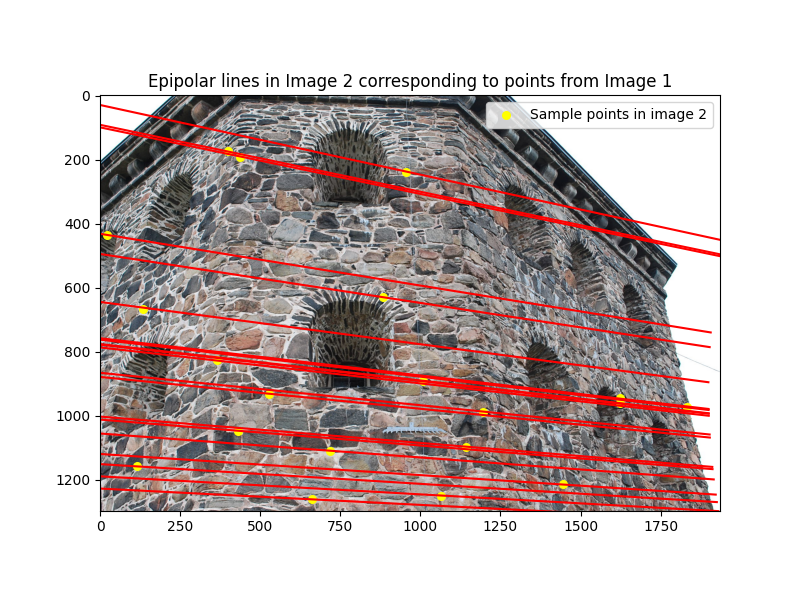

In [6]:
# ------ Your code here ------ 

# Compute un-normalized F
F = N2.T @ F_tilde @ N1
print("\nUn-normalized F:\n", F)

# Compute epipolar lines
n = 20
img2 = plt.imread(r"data/kronan2.jpg")
lines = F @ x1

N = x2.shape[1]
idx = np.random.choice(N, 20, replace=False)

pts2_sample = x2[:, idx]      
lines_sample = lines[:, idx].T  

# Visualize epipolar lines and corresponding points and check that epipolar constraints roughly fulfilled
plt.figure(figsize=(8, 6))
plt.imshow(img2)
plt.scatter(pts2_sample[0, :], pts2_sample[1, :], c='yellow', s=30, label="Sample points in image 2")

# Plot lines with rital 
rital(lines_sample, st='r-')

plt.title("Epipolar lines in Image 2 corresponding to points from Image 1")
plt.legend()
plt.show()

Compute the distance between all the points and their corresponding epipolar lines and plot these in a histogram with 100 bins.
What is the mean distance? Create a function as this would be useful later.

In [7]:
def compute_epipolar_errors(F, x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    F - Fundamental matrix (3x3)
    '''
    # Your code here
    x1s = pflat(x1s)
    x2s = pflat(x2s)

    l2 = F @ x1s
    a,b,c = l2
    x,y,_ = x2s
    
    d = np.abs(a*x + b*y + c)/np.sqrt(a**2 + b**2)

    return d

Mean distance: 0.3612331027480926
Max distance: 4.483260573625242
Min distance: 9.809264273609988e-05


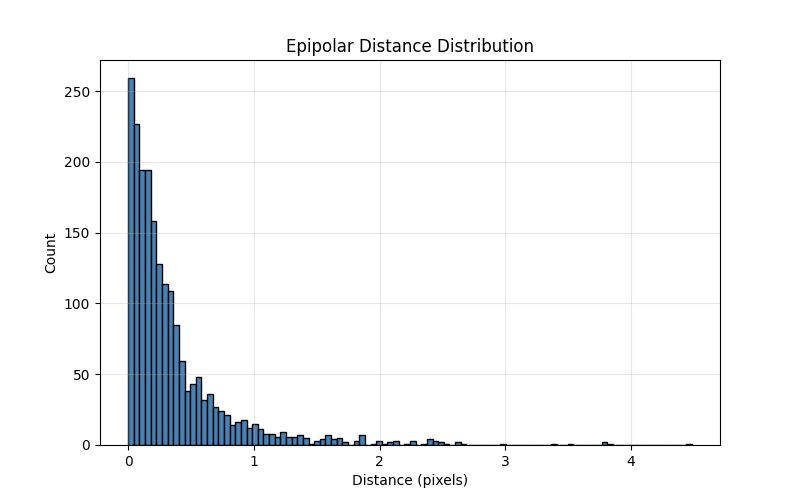

In [8]:
# ------ Your code here ------

# Compute mean epipolar distance
dists = compute_epipolar_errors(F, x1, x2)

print("Mean distance:", np.mean(dists))
print("Max distance:", np.max(dists))
print("Min distance:", np.min(dists))

# Plot epipolar distances in a histogram
plt.figure(figsize=(8,5))
plt.hist(dists, bins=100, color='steelblue', edgecolor='black')
plt.title("Epipolar Distance Distribution")
plt.xlabel("Distance (pixels)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


#### Your answer here: 

The mean distance with normalization is: 0.3612331027480926 

### Task 1.4

See what happens if we do everything without normalization (that is, set $N_1=N_2=I$ and run the code again).
What is the mean distance in this case?

In [9]:
# ------ Your code here ------

# See what happens if N1=N2=I
N1_id, N2_id = np.eye(3), np.eye(3)
x1_id = x1           
x2_id = x2

F_tilde_approx_id, sigma_min_id, residual_id = estimate_F_DLT(x1_id, x2_id)
F_tilde_id = enforce_fundamental(F_tilde_approx_id)

F_id = N2_id.T @ F_tilde_id @ N1_id

# Compute mean epipolar distance for this case
dists_id = compute_epipolar_errors(F_id, x1, x2)

print("Mean distance without normalization:", np.mean(dists_id))
print("Max distance without normalization:", np.max(dists_id))
print("Min distance without normalization:", np.min(dists_id))

Mean distance without normalization: 0.4878403579998165
Max distance without normalization: 4.232464438026419
Min distance without normalization: 0.0007597262387753276


#### 

#### Your answer here: 

The mean distance without normalization is: 0.4878403579998165


#### *Theoretical exercise 5* (see pdf)

# The Essential Matrix

#### *Theoretical exercise 6* (see pdf)

## Computer Exercise 2


### Task 2.1

The file `compEx2data.mat` contains the calibration matrix $K$ for the two images in Computer Exercise 1. 
Normalize the image points using the inverse of $K$.

Set up the matrix $M$ in the eight point algorithm, and solve the homogeneous least squares system using SVD. Check that the minimum singular value and $Mv$ are both small. You can of course re-use function `estimate_F_DLT`.

Construct the essential matrix from the solution $v$. Don't forget to make sure that $E$ has two equal singular values and the third one zero.
As the essential matrix is a homogeneous entity, scale does not matter, but for grading purposes, please also make sure that the two non-zero singular values are both equal to 1.
Check that the epipolar constraints $\tilde{x}_2^T E\tilde{x}_1 = 0$ are roughly fulfilled.

In [10]:
def enforce_essential(E_approx):
    '''
    E_approx - Approximate Essential matrix (3x3)
    '''
    # Your code here
    U, S, Vt = np.linalg.svd(E_approx)

    # Force two equal non-zero singular values and the third zero
    S_enforced = np.diag([1.0, 1.0, 0.0])

    E = U @ S_enforced @ Vt
    
    return E
    

In [11]:
# ------ Your code here ------
data = sp.io.loadmat('data/compEx2data.mat')
K = data['K']
K_inv = np.linalg.inv(K)

# Normalize the image points 
x1_normK = K_inv @ x1
x2_normK = K_inv @ x2

# Set up the matrix M in eight point algorithm and solve for v
E_approx, sigma_min, residual = estimate_F_DLT(x1_normK, x2_normK)

# Check that minimum singular value and Mv both are small
print("\nSmallest singular value:", sigma_min)
print("Residual ||M v||:", residual)

# Construct essential matrix from v (Ensuring that the two non-zero singular values are both equal to 1)
E = enforce_essential(E_approx)

U,S,Vt = np.linalg.svd(E)
print("\nSingular values of enforced E:", S)

# Check that epipolar constraints are roughly fulfilled
vals = np.sum(x2_normK * (E @ x1_normK), axis=0)
print("\nMean violation:", np.mean(np.abs(vals)))
print("Max violation:", np.max(np.abs(vals)))


Smallest singular value: 0.006626799894543161
Residual ||M v||: 0.006626799894543139

Singular values of enforced E: [1.0000000e+00 1.0000000e+00 4.8182624e-18]

Mean violation: 0.0008038774006366862
Max violation: 0.0025874977762768495


### Task 2.2

Compute the fundamental matrix for the un-normalized coordinate system from the essential matrix and compute the epipolar lines $l = F  x_1$. Pick 20 of the detected points in the second image
at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same figure using the function `rital`.

Compute the distance between the points and their corresponding epipolar lines and plot these in a histogram with 100 bins. 
**How does this result compare to the corresponding result in Computer Exercise 1?** If the errors are higher, remember that we are dealing with noisy measurements, and for the essential matrix we enforce more constraints than for the fundamental matrix. Write the following function that will be helpful for the rest of the course.

In [12]:
# Note that we in this case have K1=K2=K

def convert_E_to_F(E,K1,K2):
    '''
    A function that gives you a fundamental matrix from an essential matrix and the two calibration matrices
    E - Essential matrix (3x3)
    K1 - Calibration matrix for the first image (3x3)
    K2 - Calibration matrix for the second image (3x3)
    '''
    # Your code here
    K1_inv = np.linalg.inv(K1)
    K2_inv = np.linalg.inv(K2)

    F = K2_inv.T @ E @ K1_inv
    return F
    

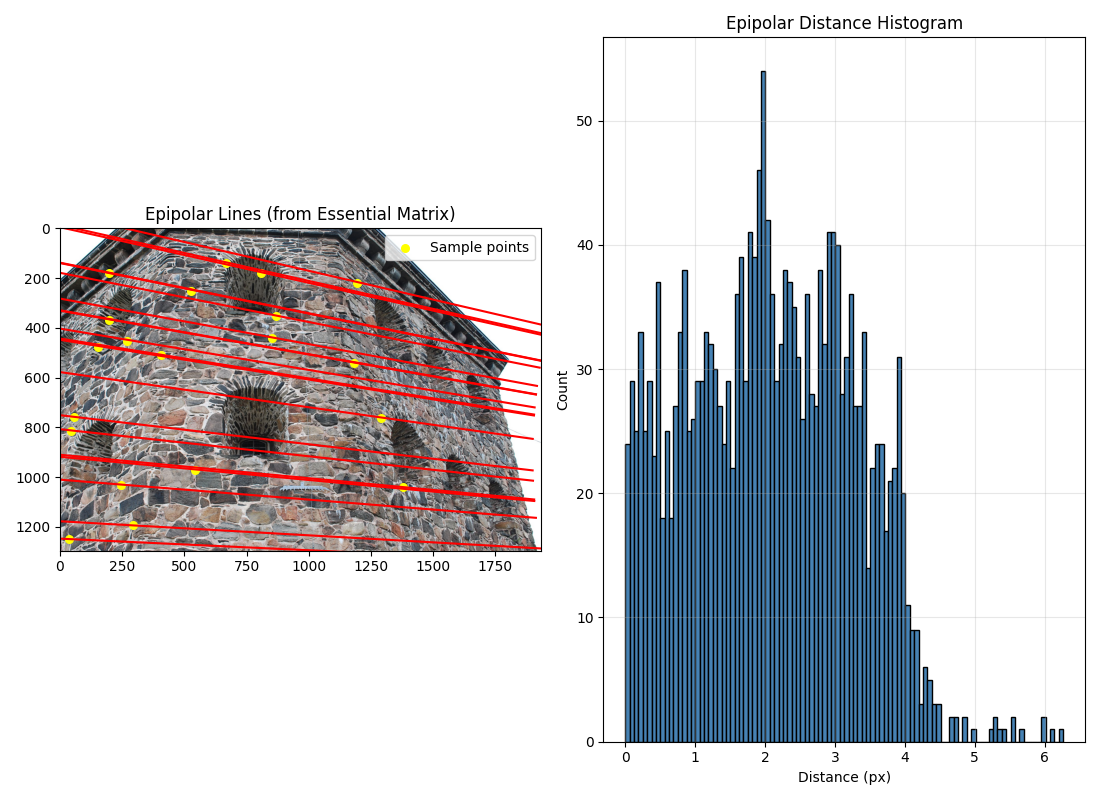

Mean epipolar distance: 2.083753202691359
Max  epipolar distance: 6.263023914969526


In [13]:
# ------ Your code here ------

# Compute the fundamental matrix from the essential matrix and compute the epipolar lines
F_from_E = convert_E_to_F(E,K,K)
lines = F_from_E @ x1

# Plot 20 of the detected points and corresponding epipolar lines in the same figure as the image
N = x2.shape[1]
idx = np.random.choice(N, 20, replace=False)

pts2_sample = x2[:, idx]
lines_sample = lines[:, idx].T 

fig, axes = plt.subplots(1, 2, figsize=(11, 8))
axes[0].imshow(img2)

axes[0].scatter(pts2_sample[0, :], pts2_sample[1, :],
                c='yellow', s=30, label='Sample points')

plt.sca(axes[0])
rital(lines_sample, st='r-')

axes[0].set_title("Epipolar Lines (from Essential Matrix)")
axes[0].legend()

# Compute the distance between the points and their corresponding epipolar lines and plots these in a histogram
dists_E = compute_epipolar_errors(F_from_E, x1, x2)
axes[1].hist(dists_E, bins=100, color='steelblue', edgecolor='black')
axes[1].set_title("Epipolar Distance Histogram")
axes[1].set_xlabel("Distance (px)")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Mean epipolar distance:", np.mean(dists_E))
print("Max  epipolar distance:", np.max(dists_E))



### Your answer here: 

Mean epipolar distance: 2.083753202691359 

Max  epipolar distance: 6.263023914969526

These values are larger indicating a worse result, as the essential matrix is more constraint noise have a larger affect on the result which is expected.

#### *Theoretical exercise 7* (see pdf)

## Computer Exercise 3


### Task 3.1

\begin{equation}
P_2 = [UWV^T \ u_3] \text{ or } [UWV^T \ -u_3]  \text{ or }
[UW^TV^T \ u_3]  \text{ or } [ UW^TV^T \ -u_3 ]
\end{equation}


For the essential matrix obtained in Computer Exercise 2 compute the four camera solutions above (make sure that `det(U*V') > 0`; otherwise set `V = -V`).

Write a function that does this for you, it will also be useful in the future. The output `P` should contain all four solutions.

In [14]:
def extract_P_from_E(E):
    
     '''
    A function that extract the four P2 solutions given above
    E - Essential matrix (3x3)
    P - Array containing all four P2 solutions (4x3x4) (i.e. P[i,:,:] is the ith solution) 
    '''
     # Your code here
     U, S, Vt = np.linalg.svd(E)

     W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

     u3 = U[:, 2]

     # Compute two possible rotation matrices
     R1 = U @ W @ Vt
     R2 = U @ W.T @ Vt

     # Ensure rotations are proper (det = +1)
     if np.linalg.det(R1) < 0: R1 = -R1
     if np.linalg.det(R2) < 0: R2 = -R2

     # Four possible camera matrices
     P = np.zeros((4, 3, 4))
     P[0] = np.hstack((R1,  u3.reshape(3,1)))
     P[1] = np.hstack((R1, -u3.reshape(3,1)))
     P[2] = np.hstack((R2,  u3.reshape(3,1)))
     P[3] = np.hstack((R2, -u3.reshape(3,1)))

     return P

In [15]:
# ------ Your code here ------

# Extract P2 from E 
P_solutions = extract_P_from_E(E)
print("P_solutions shape:", P_solutions.shape)

for i in range(4):
    print(f"\nP2 solution {i+1}:\n", P_solutions[i])



P_solutions shape: (4, 3, 4)

P2 solution 1:
 [[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0.14220198]
 [ 0.73103218  0.13579079 -0.66869485  0.35938565]]

P2 solution 2:
 [[ 0.62208686  0.27002211  0.73491224 -0.92229092]
 [ 0.28035671 -0.95323078  0.11292118 -0.14220198]
 [ 0.73103218  0.13579079 -0.66869485 -0.35938565]]

P2 solution 3:
 [[ 0.99438445  0.02933304  0.10168156  0.92229092]
 [-0.03112361  0.99938639  0.01606773  0.14220198]
 [-0.10114785 -0.01914219  0.99468723  0.35938565]]

P2 solution 4:
 [[ 0.99438445  0.02933304  0.10168156 -0.92229092]
 [-0.03112361  0.99938639  0.01606773 -0.14220198]
 [-0.10114785 -0.01914219  0.99468723 -0.35938565]]


Triangulate the points using DLT for each of the four camera solutions, and determine for which of the solutions the points are in front of the cameras.
In this exercise, you may expect to have only one solution for which all the 3D points are in front of both cameras. But in general, since there is noise involved it might not be possible to find a solution with all points in front of the cameras. (In that case the solution with the highest number of points in front of the cameras needs to be selected.)

In [16]:
# ------ Your code here ------
def triangulate_point_DLT(P1, P2, x1, x2):
    
    A = np.zeros((4, 4))

    A[0] = x1[0] * P1[2] - P1[0]
    A[1] = x1[1] * P1[2] - P1[1]
    A[2] = x2[0] * P2[2] - P2[0]
    A[3] = x2[1] * P2[2] - P2[1]

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]
    X = X / X[-1]   

    return X

def triangulate_all_points(P1, P2, x1, x2):
    N = x1.shape[1]
    Xs = np.zeros((4, N))
    for j in range(N):
        Xs[:, j] = triangulate_point_DLT(P1, P2, x1[:, j], x2[:, j])
    return Xs

def count_points_in_front(P1, P2, Xs):
    X1p = P1 @ Xs   
    X2p = P2 @ Xs   
    #in1 = X1p[2, :] > 0
    #in2 = X2p[2, :] > 0
    Z1 = X1p[2,:]*np.sign(Xs[3,:])
    Z2 = X2p[2,:]*np.sign(Xs[3,:])
    in1 = Z1 > 0
    in2 = Z2 > 0
    tot_point_in_front = np.logical_and(in1, in2)
    return np.sum(tot_point_in_front)


# Triangulate the points using DLT for each of the four camera solutions
P1 = np.hstack((np.eye(3), np.zeros((3,1))))
front_counts = []

for i in range(4):
    print(f"\nEvaluating P2[{i}]...")
    P2 = P_solutions[i]

    # Triangulate all points
    Xs = triangulate_all_points(P1, P2, x1_normK, x1_normK )
    #print(f"Xs:", Xs)
    
    # Count points in front of both cameras
    count = count_points_in_front(P1, P2, Xs)
    front_counts.append(count)

    print(f"Points in front of both cameras: {count}/{x1.shape[1]}")
    print(f"_______________________________________")



# Determine for which of the solutions the points are in front of the cameras
best_idx = np.argmax(front_counts)
P2_correct = P_solutions[best_idx]

print("\nCorrect P2 index:", best_idx)
print("Number of points in front:", front_counts[best_idx])


Evaluating P2[0]...
Points in front of both cameras: 0/2008
_______________________________________

Evaluating P2[1]...
Points in front of both cameras: 0/2008
_______________________________________

Evaluating P2[2]...
Points in front of both cameras: 0/2008
_______________________________________

Evaluating P2[3]...
Points in front of both cameras: 2008/2008
_______________________________________

Correct P2 index: 3
Number of points in front: 2008


Compute the corresponding camera matrices for the original (un-normalized) coordinate system and plot the image points and the projected 3D-points in the same figure.
**Do the errors look small?**
Verify that the projections are reasonably well aligned with the image points.

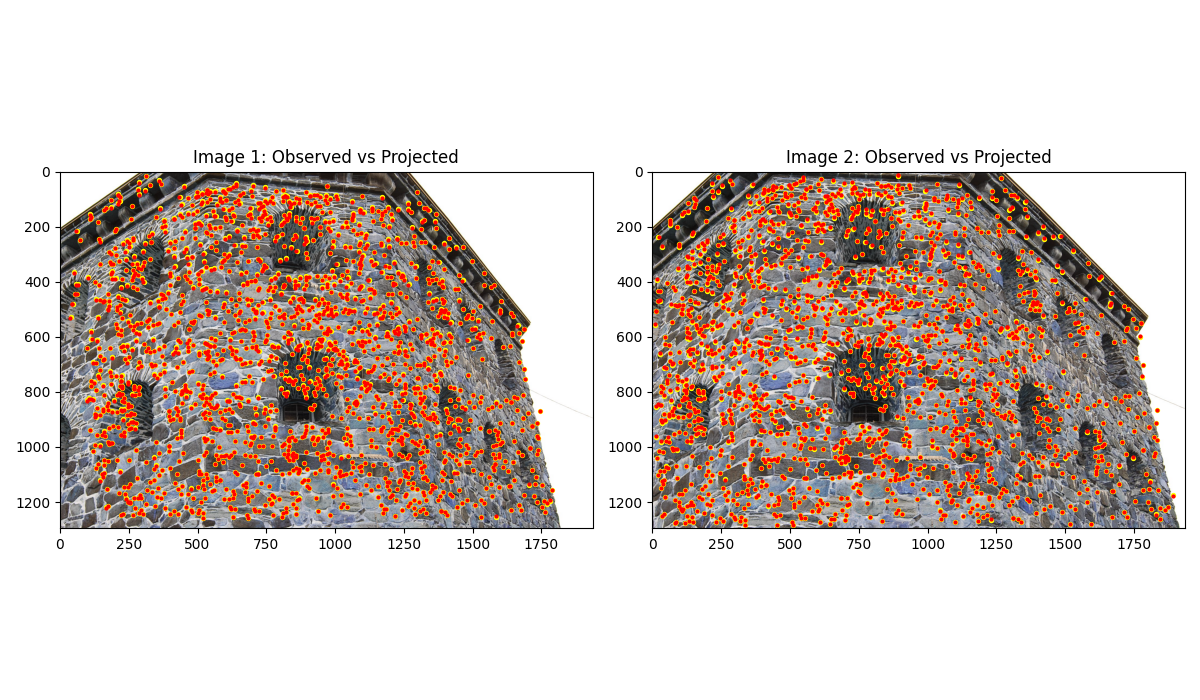

Mean reprojection error Image 1: 0.9891562003149263
Mean reprojection error Image 2: 1.0411589395328338
Max reprojection error Image 1: 2.9520175045711703
Max reprojection error Image 2: 3.1310618723729604


In [17]:
# ------ Your code here ------
# Reuse ploting functions from previous assignments
from utils import *
img1 = cv2.imread('data/kronan1.jpg')
img2 = cv2.imread('data/kronan2.jpg')

# Compute the corresponding camera matrices for the original (un-normalized) coordinate system 
P1_original = K @ P1
P2_original = K @ P2_correct

X_all = triangulate_all_points(P1, P2_correct, x1_normK, x2_normK)

x1_proj = pflat(K @ P1 @ X_all)[0:2,:]
x2_proj = pflat(K @ P2_correct @ X_all)[0:2,:]

# Plot the image points and the projected 3D-points in the same figure 
fig, axes = plt.subplots(1, 2, figsize=(12,7))

# IMAGE 1
axes[0].imshow(img1)
plot_points_2D(x1, ax=axes[0], color='yellow', size=8)
plot_points_2D(x1_proj, ax=axes[0], color='red', size=4)
axes[0].set_title("Image 1: Observed vs Projected")

# IMAGE 2
axes[1].imshow(img2)
plot_points_2D(x2, ax=axes[1], color='yellow', size=8)
plot_points_2D(x2_proj, ax=axes[1], color='red', size=4)
axes[1].set_title("Image 2: Observed vs Projected")

plt.tight_layout()
plt.show()

# 5. Compute reprojection errors
err1 = np.sqrt(np.sum((x1[:2,:] - x1_proj)**2, axis=0))
err2 = np.sqrt(np.sum((x2[:2,:] - x2_proj)**2, axis=0))

print("Mean reprojection error Image 1:", np.mean(err1))
print("Mean reprojection error Image 2:", np.mean(err2))
print("Max reprojection error Image 1:", np.max(err1))
print("Max reprojection error Image 2:", np.max(err2))

Plot the 3D points and camera centers and principal axes in a 3D plot.
**Does it look like you expected it to ?**

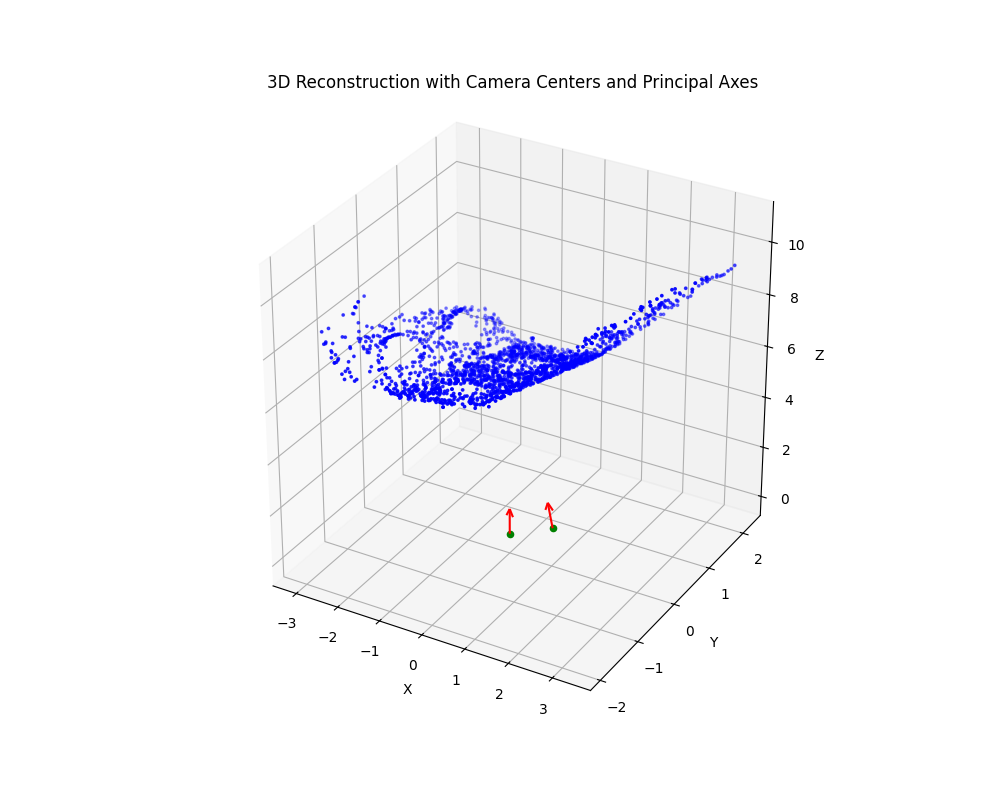

In [18]:
# ------ Your code here ------

# Plot the 3D points and camera centers and principal axes in a 3D plot 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

X_euclid = X_all[:3, :]

# Plot 3D points
plot_points_3D(X_euclid, ax=ax, size=3, kwargs={'color':'blue'})

# Plot Camera 1 
plot_camera(P1, scale=1, ax=ax)

# Plot Camera 2 
plot_camera(P2_correct, scale=1, ax=ax)

# Labels and formatting
ax.set_title("3D Reconstruction with Camera Centers and Principal Axes")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1,1,1])

plt.show()

### Your answer here: 

Yes the errors are small and the projected and observed points align well in the image

It looks as expected, you can see the walls and the structure of Kronan and the points are in front of the cameras as expected.